In [69]:
from __future__ import division
from numpy import linalg as LA

import numpy as np

np.set_printoptions(threshold=np.inf)
import sys
import librosa
import matplotlib.pyplot as plt

In [160]:
L = 512  # frame length
M = 500  # overlapping windows

params = {

    'rule_1': {
        'n_iter': 2000  # n_iter
    },

    'rule_2': {
        'error': 10 ** -50
    },

    'verbose': True
}

signal, fs = librosa.core.load('./dataset/noisy.wav')
K = 2500

In [161]:
noise = np.random.normal(0,0.1,len(signal))

In [156]:
noisy_signal = np.array(signal) + noise

In [157]:
librosa.output.write_wav("dataset/noisy.wav",noisy_signal, fs)

In [158]:
X = []
for k in range(1,K+1):
    xk = signal[(k-1) * (L-M) + 1 : k * L - (k - 1) * M + 1]
    X.append(xk)
X = np.array(X).T

In [159]:
X.shape

(512, 2500)

In [153]:
def unbuffer(X, hop):
    N, L = X.shape

    T = N + L * hop
    K = np.arange(0, N)
    x = np.zeros(T)
    H = np.hanning(N)
    for k in xrange(0, L):
        x[K] = x[K] + np.multiply(H, X[:, k])
        K = K + hop

    return x

In [119]:
class GAD():
    def __init__(self, X, params):

        self.X = X
        self.D = []
        self.params = params
        self.n_iter = self.params['rule_1']['n_iter']  # num_iterations
        self.verbose = self.params['verbose']

        self.K = self.X.shape[0]  # sample length
        self.L = self.X.shape[1]  # maximum atoms to be learned

        self.I = np.arange(0, self.L)
        self.set_ind = []

    def findResidualColumn(self):

        # Find residual column of R^l with lowest l1- to l2-norm ration
        tmp = []

        # COMPACT WAY TO DO IT
        # tmp2 = np.sum(np.abs(self.R),axis=0)/np.sqrt(np.sum(np.power(np.abs(self.R),2),axis=0))
        for k in self.I:
            r_k = self.R[:, k]
            tmp.append(LA.norm(r_k, 1) / LA.norm(r_k, 2))

        ind_k_min = np.nanargmin(tmp)  # nanargmin, nanmin
        k_min = tmp[ind_k_min]
        r_k_min = self.R[:, self.I[ind_k_min]]

        # Set the l-th atom to equal to normalized r_k
        psi = r_k_min / LA.norm(r_k_min, 2)

        # Add to the dictionary D and its index and shrinking set I
        self.D.append(psi)
        self.set_ind.append(self.I[ind_k_min])

        # COMPACT WAY TO DO IT
        # self.R = self.R - np.dot(np.outer(psi, psi), self.R)
        # self.R = np.delete(self.R, (ind_k_min), axis=1)

        # Compute the new residual for all columns k
        for k in self.I:
            r_k = self.R[:, k]
            alpha = np.dot(r_k, psi)
            self.R[:, k] = r_k - np.dot(psi, alpha)

        self.I = np.delete(self.I, ind_k_min)

    def iterative_GAD(self):

        # X columns w/ unit L2-norm
        # for k in xrange(0,self.X.shape[1]):
        #     self.X[:,k] = np.divide(self.X[:,k],LA.norm(self.X[:,k],2))


        if self.n_iter > self.L:
            print ('Cannot be learned more than %d atom!' % (self.L))
            sys.exit()

        # Initializating the residual matrix 'R' by using 'X'
        self.R = self.X.copy()

        print self.I.shape
        for l in xrange(0, self.n_iter):

            if self.verbose == True and l % 100 == 0:
                print 'GAD iteration: ', l + 1

            self.findResidualColumn()

        self.D = np.vstack(self.D).T

        return self.D, self.set_ind

In [122]:
X.shape

(20000,)

In [120]:
alg = GAD(X, params)

D, I = alg.iterative_GAD()

X_t = np.dot(np.dot(D, D.T), X)

IndexError: tuple index out of range

In [121]:
out = []
for k in range(K):
    out += list(X.T[k][:-M])

In [94]:
s_rec = unbuffer(X_t, L - M)

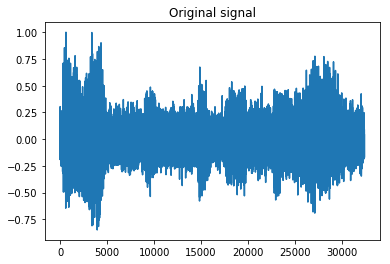

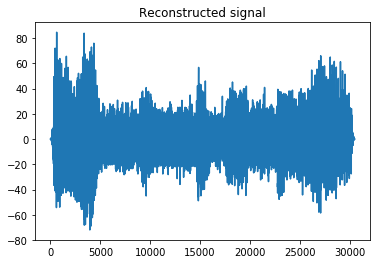

In [95]:
plt.figure(1)
plt.title('Original signal')
plt.plot(signal)

plt.figure(2)
plt.title('Reconstructed signal')
plt.plot(s_rec)

plt.show()

In [162]:
librosa.output.write_wav("out.wav",s_rec, fs)

In [52]:
fs

22050